In [3]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


# Use Case: Ein Recommender System für Filme
* Collaborativer Item-Item Filter
* Szenario:
    * <font color=green>Eingabe:</font> ein Film (den der User gerade gesehen hat)
    * <font color=blue>Ausgabe:</font> Liste von Filmen die als nächstes geschaut werden könnten
<BR>    
<font color=red>"User die diesen Film gesehen haben, sahen auch ..."</font>

### Daten: freie Datenbank mit Filmbewertungen: http://www.movielens.org/
* 943 User, 1682 Filme und 100000 Bewertungen
* Download als CSV Datei
<img src="IMG/movielens.png" width=75%>

### Movielens Datenstrukturen
* Relationale Datendank mit drei Tabellen [users, ratings, movies]
<img src="IMG/mtable.png" width=75%>

### Datenimport:

In [5]:
#read data to DataFrames
import pandas as pd
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )


### Dann schauen wir uns die Daten doch mal an ...

In [6]:
import numpy as np
print (np.shape(users), np.shape(ratings), np.shape(movies))
print (ratings[1:10])


(943, 5) (100000, 4) (1682, 24)
   user_id  movie_id  rating  timestamp
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
5      298       474       4  884182806
6      115       265       2  881171488
7      253       465       5  891628467
8      305       451       3  886324817
9        6        86       3  883603013


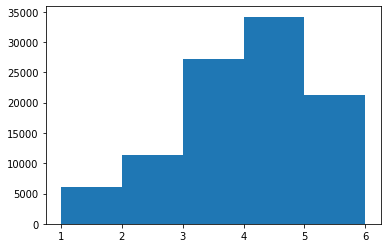

In [7]:
#schauen wir uns mal die die Verteilung der ratings an
import matplotlib.pyplot as plt
%matplotlib inline
res=plt.hist(ratings['rating'],[1,2,3,4,5,6])

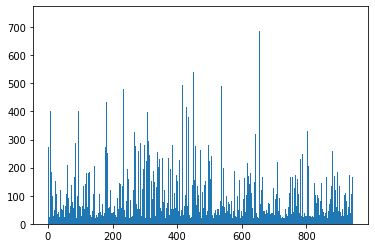

In [8]:
#wie viele Bewertungen geben user ab?
res=plt.hist(ratings['user_id'],943)

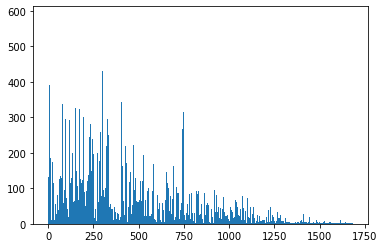

In [9]:
#wie oft werden Filme bewertet?
res=plt.hist(ratings['movie_id'],1682)

# Formalisierung: ein Item-Item Collaborative Filter

* User: $U := \{u_1, \dots, u_n\}, |U|=n$ <BR><BR>
* Filme (Produkte): $P := \{p_1, \dots, p_m\}, |P|=m$ <BR><BR>
* Kontext: Matrix $R$ der Größe $n\times m$<BR> mit Bewertungen $r_{ij},$ mit $ i\in 1\dots n, j\in 1\dots m$


In [10]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

### Plot $R$

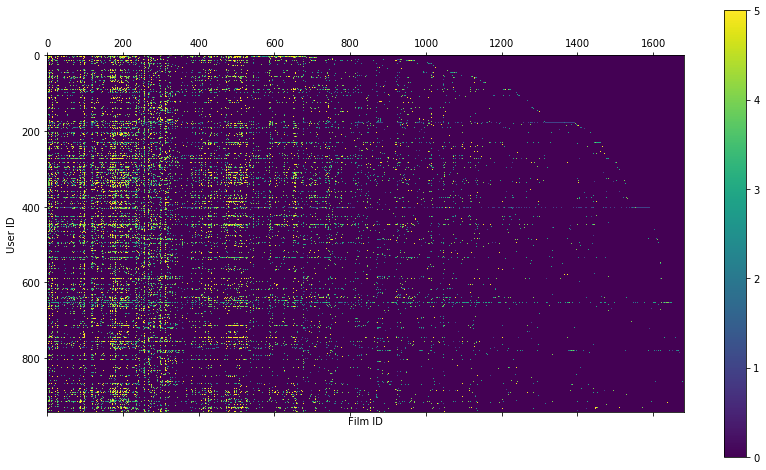

In [11]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
#show matrix    
plt.matshow(R)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()


## Distanzmaße 
<br>
In $R$ sind alle 
* Bewertungen des $i$-ten Films im $i$-ten Spaltenvektor abgelegt
* Bewertungen des $j$-ten Users im $j$-ten Zeilenvektor abgelegt 
<BR><BR>

### Filmbewertungen := Spaltenvektoren in der Kontext Matrix $R$
<img src="IMG/R.png">


### Items: Kosinus-Distanz:
Für Filmbewertungen := Spaltenvektoren $\vec{a},\vec{b}$ in $R$ gilt die Distanz:<BR><BR>
$d_{cos}(\vec{a},\vec{b}) := { <\vec{a},\vec{b}> \over |\vec{a}||\vec{b}|}$ <BR><BR>
* mit den Skalarprodukt $ <\vec{a},\vec{b}>$<BR>
* und der Vektornorm $|\vec{a}|$<BR>
* mit dem Wertebereich  zwischen $0$ (keine Ähnlichkeit) und $1$ (Identisch)<BR>


In [12]:
 def CosineDist(a,b):
    res =  a.dot(b)
    norm = np.linalg.norm(a)*np.linalg.norm(b)
    if norm > 0: #norm ist null wenn keine Berwerung existiert -> Fallunterscheidung
        return res/norm
    else:
        return res

### Erstelle Kosinus-Distanz Matrix für alle Filme (offline)

In [13]:
#implementation with for-loops is not efficient!
#D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
#for i in range(0,np.shape(movies)[0]):
#    for j in range(0,np.shape(movies)[0]):
#        if i!=j:
#            D[i,j]=CosineDist(R[:,i],R[:,j])

import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

In [14]:
np.save("movie_dist",D)

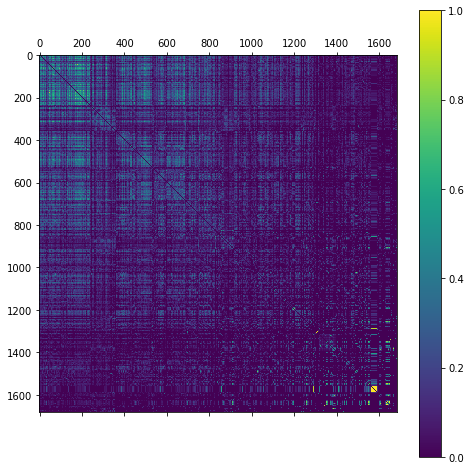

In [15]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D)
plt.colorbar() 

### Anfragen an die Distanz-Matrix
* Suche die Top-5 ähnlichsten Filme 
* argmax auf Spalten / Zeilen von $D$
<img src="IMG/D.png" width="200">

In [28]:
def getTopN(movie_id,D, N=5):
    return D[movie_id,:].argsort()[-N:]


### Hilfsfunktionen

In [29]:
def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

## Implementierung Collaborative Item-Item Filter

In [30]:
def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        

In [40]:
CII("war",D)

recommending movies for: 'Snow White and the Seven Dwarfs (1937)'


587    Beauty and the Beast (1991)
417              Cinderella (1950)
403               Pinocchio (1940)
431                Fantasia (1940)
500                   Dumbo (1941)
Name: title, dtype: object

In [44]:
#wie oft kommt ein Film (per ID) in der DB for
id=123
print(movies.title[id])
np.sum(ratings.movie_id==id)

Lone Star (1996)


115

## Quallitätsicherung - wie gut ist unser System objekitv?

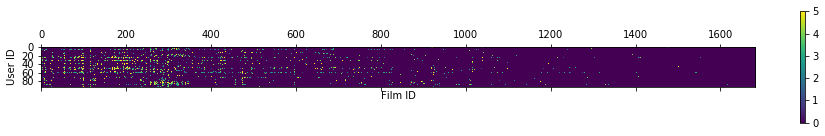

In [47]:
#split into train and test data
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)
plt.matshow(R_test)
plt.xlabel('Film ID')
plt.ylabel('User ID')
plt.colorbar()

In [49]:
D_train=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
D_train=np.abs(np.nan_to_num( D_train-1))

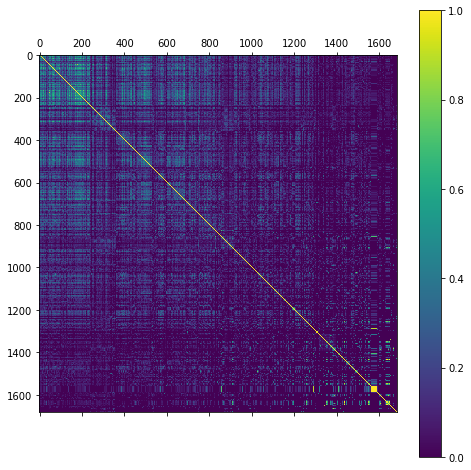

In [50]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D_train)
plt.colorbar() 

In [52]:
#Anfrage auf dem Trainingsdatensatz
CII("war",D_train)

recommending movies for: 'Snow White and the Seven Dwarfs (1937)'


98     Snow White and the Seven Dwarfs (1937)
587               Beauty and the Beast (1991)
417                         Cinderella (1950)
403                          Pinocchio (1940)
431                           Fantasia (1940)
Name: title, dtype: object

In [53]:
#get top 5 ids from random test user 23
np.argsort(R_test[23])[-5:]

array([310, 339, 285, 241, 886])

In [54]:
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    

In [55]:
Score_byID(326,D_train, R_test[23])

(array([326, 301, 332, 267, 287]),
 326             Cop Land (1997)
 301    L.A. Confidential (1997)
 332            Game, The (1997)
 267          Chasing Amy (1997)
 287               Scream (1996)
 Name: title, dtype: object,
 array([0., 0., 0., 0., 0.]),
 0.0)

In [56]:
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [57]:
test_res=test_Score(D_train,R_test)

(array([ 6.,  6., 12., 11., 19., 21.,  6.,  3.,  9.,  2.]),
 array([1.   , 1.368, 1.736, 2.104, 2.472, 2.84 , 3.208, 3.576, 3.944,
        4.312, 4.68 ]),
 <a list of 10 Patch objects>)

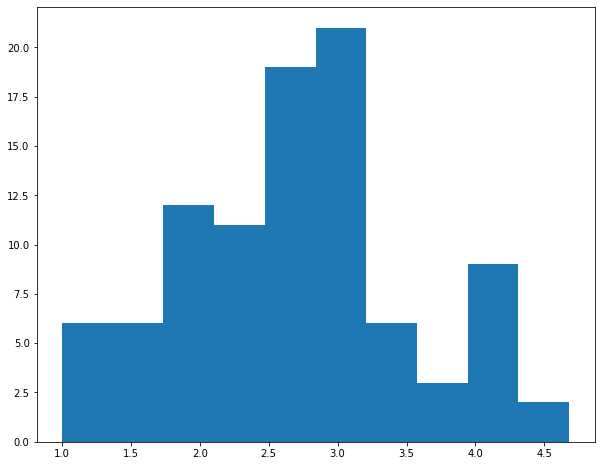

In [58]:
plt.hist(test_res)

In [59]:
np.mean(test_res)

2.7069473684210528